# In this tutorial we will be building two facial expression classifiers from a labelled dataset FER2013. 


We will be using two models, 1) Multi-Layer perceptron model (MLP) 2) CNN-based model to perform facial expression classification. 

## Install necessary python packages 

Run the below commands if these packages are not installed in your system. 

- pip install pandas
- pip install torch
- pip install -U scikit-learn

For visualisation

- pip install matplotlib
- pip install seaborn

You can also use conda to install the packages.

## Obtaining the data 
Download the data from the below link (icml_face_data.csv) and save it in the project folder </br>  
https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data?select=icml_face_data.csv



## Credits

- https://www.kaggle.com/alinaspasskaya/lab-2-face-emotion-classification-with-mlp
- https://www.kaggle.com/sharadhaviswanathan/imageclassification-facialexpression


## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import f1_score

## torch packages
import torch
from torch import nn
from torch.nn import functional as F

## Obtaining and Preprocessing the data

In data preparation the first step will be getting the train, validation and test splits of the data and this applies across all the modalities.Preprocessing the dataset varies based on both dataset and the model architecture in place. For example, some model architecture requries certain image dimensions. 


####  Currently this code does not involve much preprocessing. We will cover some in the upcoming tutorial. Some of the recommended methods that you can check out are to further improve the model are,

1. Random data augmentation (to help generalisability of the model)
2. Oversampling or Undersampling the data to makeup for the imbalance in the data (visualizing the class distribution can help)


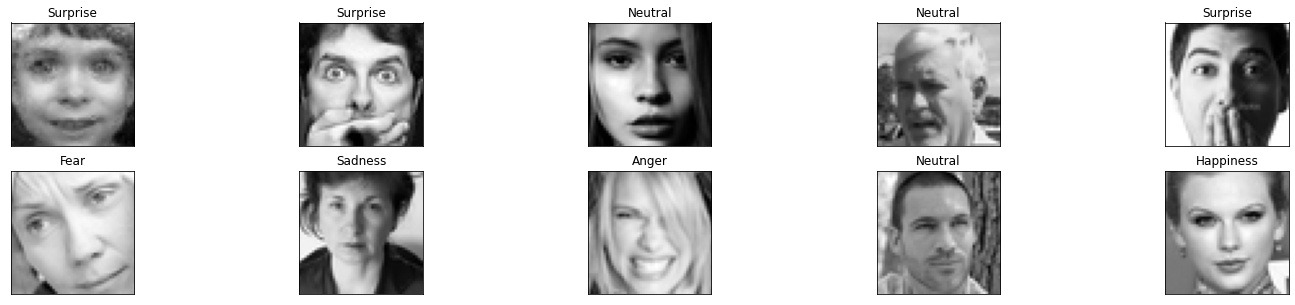

In [2]:
data_path = "./icml_face_data.csv"
data = pd.read_csv(data_path) ## Grayscale images

# (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
emotion_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']


def parse_data(data):
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(data["emotion"].values) 
    
    for i, row in enumerate(data.index):
        
        ## .loc indexes the pandas row based on the index
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ') 
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

# Splitting the data into train, validation and testing set thanks to Usage column
train_imgs, train_lbls = parse_data(data[data[" Usage"] == "Training"])
val_imgs, val_lbls = parse_data(data[data[" Usage"] == "PublicTest"])
test_imgs, test_lbls = parse_data(data[data[" Usage"] == "PrivateTest"])



def sample_plot(x,y=None):    #x, y are numpy arrays
    n = 10 ## number of images to show
    samples = random.sample(range(x.shape[0]),n) ## choose n random samples
    
    fig, axs = plt.subplots(2,5, figsize=(25,5)) ## 2*5 = n, change these values to change the arrangement of the images
    ax = axs.ravel()
    for i in range(n):
        ax[i].imshow(x[samples[i],:,:], cmap=plt.get_cmap('gray'))
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        if y is not None:
            ax[i].set_title(emotion_labels[y[samples[i]]])

sample_plot(train_imgs,train_lbls)

## Structuring the dataset to pass it through a dataloader in Pytorch

The below code creates a custom Pytorch dataset which helps the dataloader to access the data to create the batches.

In [3]:
class FER2013_Dataset(torch.utils.data.Dataset):
    
    def __init__(self,imgs,labels):

        self.imgs = imgs
        self.labels = labels
    
    def __len__(self):
        
        return len(self.imgs)
    
    def __getitem__(self, index):

        img = torch.FloatTensor(self.imgs[index])
        label = self.labels[index]
        return img, label

    
train_dataset = FER2013_Dataset(train_imgs, train_lbls)
valid_dataset = FER2013_Dataset(val_imgs, val_lbls)
test_dataset = FER2013_Dataset(test_imgs, test_lbls)

## Defining the model architecture - A simple Neural Network

The Multi-Layer Perceptron (MLP) model defined below comprises of two dense layers with ReLU activation and an output layer. The input image of size 48 x 48 is flattened to form the input to the model. Please refer to the code for the dimension detail of each layer. 

In [21]:
class MLP(nn.Module):
    
    # define model layers
    def __init__(self,img_size,output_size):
        super(MLP, self).__init__()
        
        self.flatten_img_size = img_size[0]*img_size[1]
        self.flatten_fc = nn.Linear(self.flatten_img_size,120)
        self.fc1 = nn.Linear(120,84)
        self.output_layer = nn.Linear(84,output_size)
        
    
    def forward(self, img):
        img = img.view(-1,self.flatten_img_size) ## img size: Batch size x 48 x 48 --> Batch size x 2304
        
        embedding = self.flatten_fc(img) ## Batch size x 2304 --> Batch size x 120
        
        embedding = F.relu(embedding) ## Applying non-linear activation after a dense layer
        
        embedding =  F.relu(self.fc1(embedding))  ## Batch size x  120--> Batch size x 84
        
        logits =  self.output_layer(embedding)    ## Batch size x 84 --> Batch size x output size
         
        return logits



## Defining the model architecture - A basic CNN classifier

The CNN Model defined below have two 2D convolution with maxpooling layers. The output of which is then flattened to pass through dense layers to get the output. The dimension details of these layers are provided in the code. Please refer to  https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html for understanding the input and output sizes with different settings of kernel sizes and strides. 


In [29]:
class CNN_Net(nn.Module):

    def __init__(self):
        super(CNN_Net, self).__init__()

        # kernel
        self.conv1 = nn.Conv2d(1,6,3) ## in channel, out channel = 6, kernel size = 3x3
        self.maxpool1 =  nn.MaxPool2d(2) ## (kernel = 2x2 and default stride = kenel_size)
        
        self.conv2 = nn.Conv2d(6,16,4) ## in channel, out channel = 16, kernel size = 4x4
        self.maxpool2 =  nn.MaxPool2d(2)
        
        self.fc1 = nn.Linear(16*10*10, 120) ## out channel x height x width after convolution and pooling layers
        self.fc2 = nn.Linear(120, 84)
        self.output_layer = nn.Linear(84, 7)

    def forward(self, x):
        
        x = x.unsqueeze(1) ## x : Batch size x 1 x 48 x 48
        
        ### WITH THE DEFAULT SETTINGS OF PYTORCH i.e stride=1, padding=0, dialation=1
        ### Conv2D: (h_out = h_in - kernel_size[0] +1), (w_out = w_in - kernel_size[1] + 1) 
        
        x = F.relu(self.conv1(x)) ## x : Batch size x 6 x 46 x 46

        x = self.maxpool1(x) ## x : Batch size x 6 x 23 x 23   

        x = F.relu(self.conv2(x))  ## x : Batch size x 6 x 20 x 20   
        
        x = self.maxpool2(x) ## x : Batch size x 16 x 10 x 10 
        
        x = torch.flatten(x, 1) # flatten, x : Batch size x 1600 

        x = F.relu(self.fc1(x)) # x : Batch size x 120
        
        x = F.relu(self.fc2(x)) # x : Batch size x 84 
        
        x = self.output_layer(x) # x : Batch size x 7
        
        return x


 <font color='red'> <b> >> CHANGE THE PARAMETERS IN THE BELOW CELL</font>

## Getting things ready for training

A fairly general checklist,

1. Parmeter settings
2. Choose the model
3. Initialise the data loaders using the created dataset
4. Loss function
5. Optimiser
6. Learning rate scheduler (You can try adding this)

Please set the random seed to help get same results for every run in a particular machnine. 
    
###### Do note that the choice of the items in this checklist is highly dependant on your choice of task, model and data.

In [30]:
## SET THE SEED FOR GETTING THE SAME RESULTS AGAIN
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

## Parameter settings
nepoch = 10
learning_rate = 0.001
batch_size = 64
model_arch = "cnn_net"
output_size = len(emotion_labels)

# MODEL
if model_arch == "mlp":
    model = MLP((48,48),output_size) ## 48x48 is the input size of FER2013 dataset
elif model_arch == "cnn_net":
    model = CNN_Net()
    

# DATA LOADER

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = batch_size,shuffle= True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size = 1,shuffle= False)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = 1,shuffle= False)

# LOSS
loss_fn = nn.CrossEntropyLoss()  ## applies softmax to the logits before computing the loss 


# OPTIMISER
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)



## Training

The training dataset is divided into batches by the dataloader. The weights of the model are updated after learning every batch. Here, we choose the best model based on the validation performance (accuracy). The best validation accuracy for MLP model comes around ~33% and for CNN Model around ~49% . </br>

Currently the model is ran for "nepoch" number of times, early stopping can be employed to prevent overfitting

In [37]:
for epoch in range(nepoch):  # loop over the dataset multiple times
    train_loss = 0
    train_acc = 0
    best_criterion = 0
    
    ## model in training mode
    model.train()
    for i, data in enumerate(train_loader):
        
        inputs, target = data
        
        ## to clear accumulated gradients
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs,target)
        
        ## computes the gradients
        loss.backward()
        ## updates the parameters
        optimizer.step()
        
        train_loss += loss.item()
        
        pred = torch.argmax(outputs,dim=1)
       
        num_correct = (pred==target).sum().item()
        train_acc += num_correct/inputs.size()[0]
   
    
    val_acc = 0
    val_loss = 0
    ## model in evaluation mode
    model.eval()
    
    
    with torch.no_grad(): ## disables gradient calculation
        
        for data in valid_loader:
            inputs, target = data
            
            outputs = model(inputs)
            loss = loss_fn(outputs, target)
            
            ## takes the class with high predicition probability
            pred = torch.argmax(outputs,dim=1)
       
            num_correct = (pred==target).sum().item()
            
            val_acc += num_correct/inputs.size()[0]
            val_loss += loss.item()
            
    print("Epoch:{} Train Loss:{:.2f} Train Accuracy:{:.2f} Val Loss:{:.2f} Val Accuracy:{:.2f}".format(epoch,train_loss/len(train_loader),(train_acc/len(train_loader))*100,val_loss/len(valid_loader),(val_acc/len(valid_loader))*100))
    
    ## Saves the best model by tracking the validation accuracy
    if val_acc > best_criterion:
        torch.save(model.state_dict(),"./{}_model_best.pth.tar".format(model_arch))

    best_criterion = max(best_criterion,val_acc)
    

    

Epoch:0 Train Loss:0.69 Train Accuracy:75.30 Val Loss:1.68 Val Accuracy:47.09


KeyboardInterrupt: 

## Testing

In the testing phase,the weights of the best model from the training phase is loaded to get the evaluation performance on the test dataset. The best validation accuracy for MLP model comes around ~28% and for CNN Model around ~47%. </br>

We also measure the weighted F1 score, we use the weighted version due imbalance in the class distribution. 



In [32]:
if model_arch == "mlp":
    model = model = MLP((48,48),output_size)
elif model_arch == "cnn_net":
    model = CNN_Net()


conf_matrix = torch.zeros(output_size,output_size) ## CONFUSION MATRIX
total_num_samples = torch.zeros(output_size) ## KEEPS COUNT OF TOTAL NUMBER OF SAMPLES PER CLASS

model.load_state_dict(torch.load("./{}_model_best.pth.tar".format(model_arch)))
model.eval()

test_acc = 0
total = 0
y_pred,y_true = [],[]

model.eval()

with torch.no_grad():
    for data in test_loader:
        inputs, target = data

        outputs = model(inputs)

        pred = torch.argmax(outputs,dim=1)

        num_correct = (pred==target).sum().item()

        test_acc += num_correct/inputs.size()[0]
        
        
        for t, p in zip(target.data, pred):
            conf_matrix[t.long(), p.long()] += 1
            total_num_samples[t.long()] +=1
    
        y_pred.extend(pred.tolist())
        y_true.extend(target.data.tolist())
            
## Weighted F1 score calculation, can change the average to "macro" for the unweighted version

test_f1 = f1_score(y_true, y_pred, labels=list(range(0,output_size)),average='weighted')

print("Test Accuracy: {:.2f} Test F1: {:.2f}".format((test_acc/len(test_loader))*100,(test_f1)*100))

Test Accuracy: 47.39 Test F1: 47.62


## Visualisation : Confusion matrix

Confusion matrix helps visualise the misclassifications amongst the classes. Here, the confusion matrix is normalised by dividing each row with total number of samples in the class represented by the row. The diagonals of the matrix gives the per class accuracy of each class.


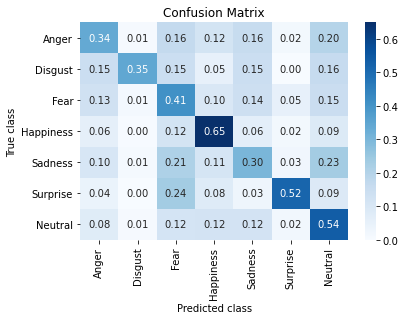

In [38]:
import seaborn as  sns

## NORMALISING THE CONFUSION MATRIX
normalised_conf_matrix = torch.div(conf_matrix,total_num_samples.unsqueeze(-1)) 

ticklabels = emotion_labels
sns.heatmap(normalised_conf_matrix,annot=True, fmt=".2f",xticklabels=ticklabels,yticklabels=ticklabels,cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted class")
plt.ylabel("True class")

plt.show()


## This performance can be further improved by using transfer learning which will be explained in detailed in the upcoming tutorial. Stay tuned !!